# Import packages

In [14]:
import warnings
import scirpy as ir
warnings.simplefilter(action='ignore', category=FutureWarning)
from mousipy import translate
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import muon as mu
%matplotlib inline
from glob import glob
import anndata
sc.set_figure_params(dpi=100)
import warnings
warnings.filterwarnings('ignore')
import scprep
from statannot import add_stat_annotation

# Import Object Concatenated

In [15]:
adata = sc.read("/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/H5ad/Part2_TcellCD4_raw.h5ad")

In [16]:
adata

AnnData object with n_obs × n_vars = 6409 × 16482
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'batch', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'Gene type', 'Gene description', 'n_cells'
    layers: 'log', 'log1', 'raw'

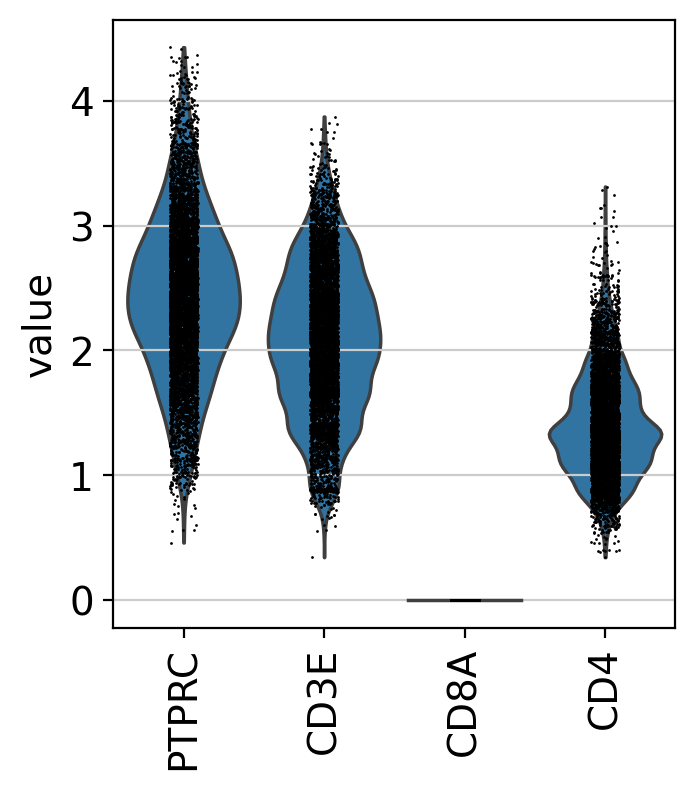

In [17]:
sc.pl.violin(adata, keys=['PTPRC','CD3E','CD8A','CD4'],  rotation=90)

In [18]:
adata.layers['log'] =  adata.X.A

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)

# Feature Selection

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
# This saves the original set of genes 
adata.raw = adata

adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

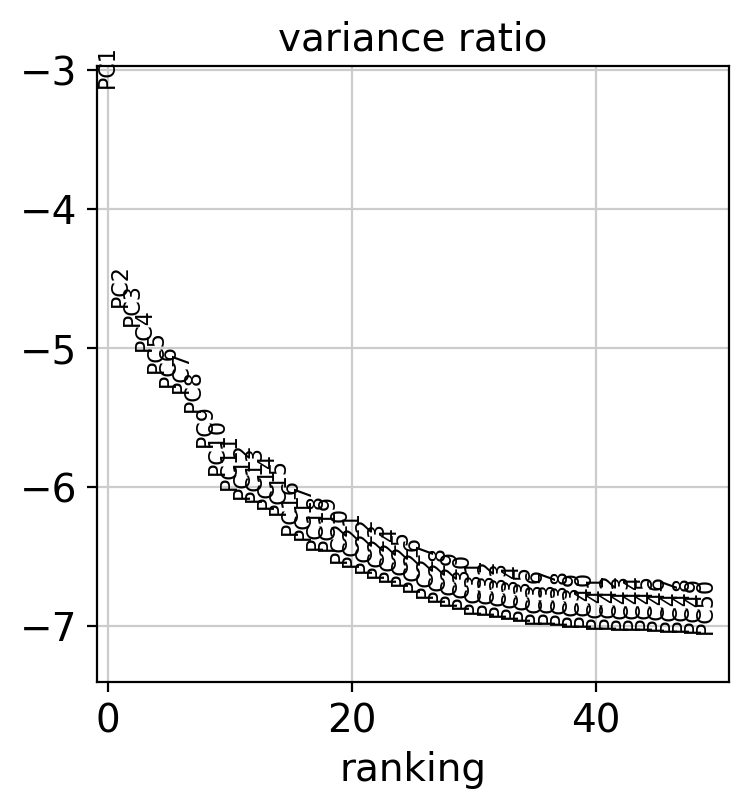

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save='') # scanpy generates the filename automatically

# Umap before Correction

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.5)

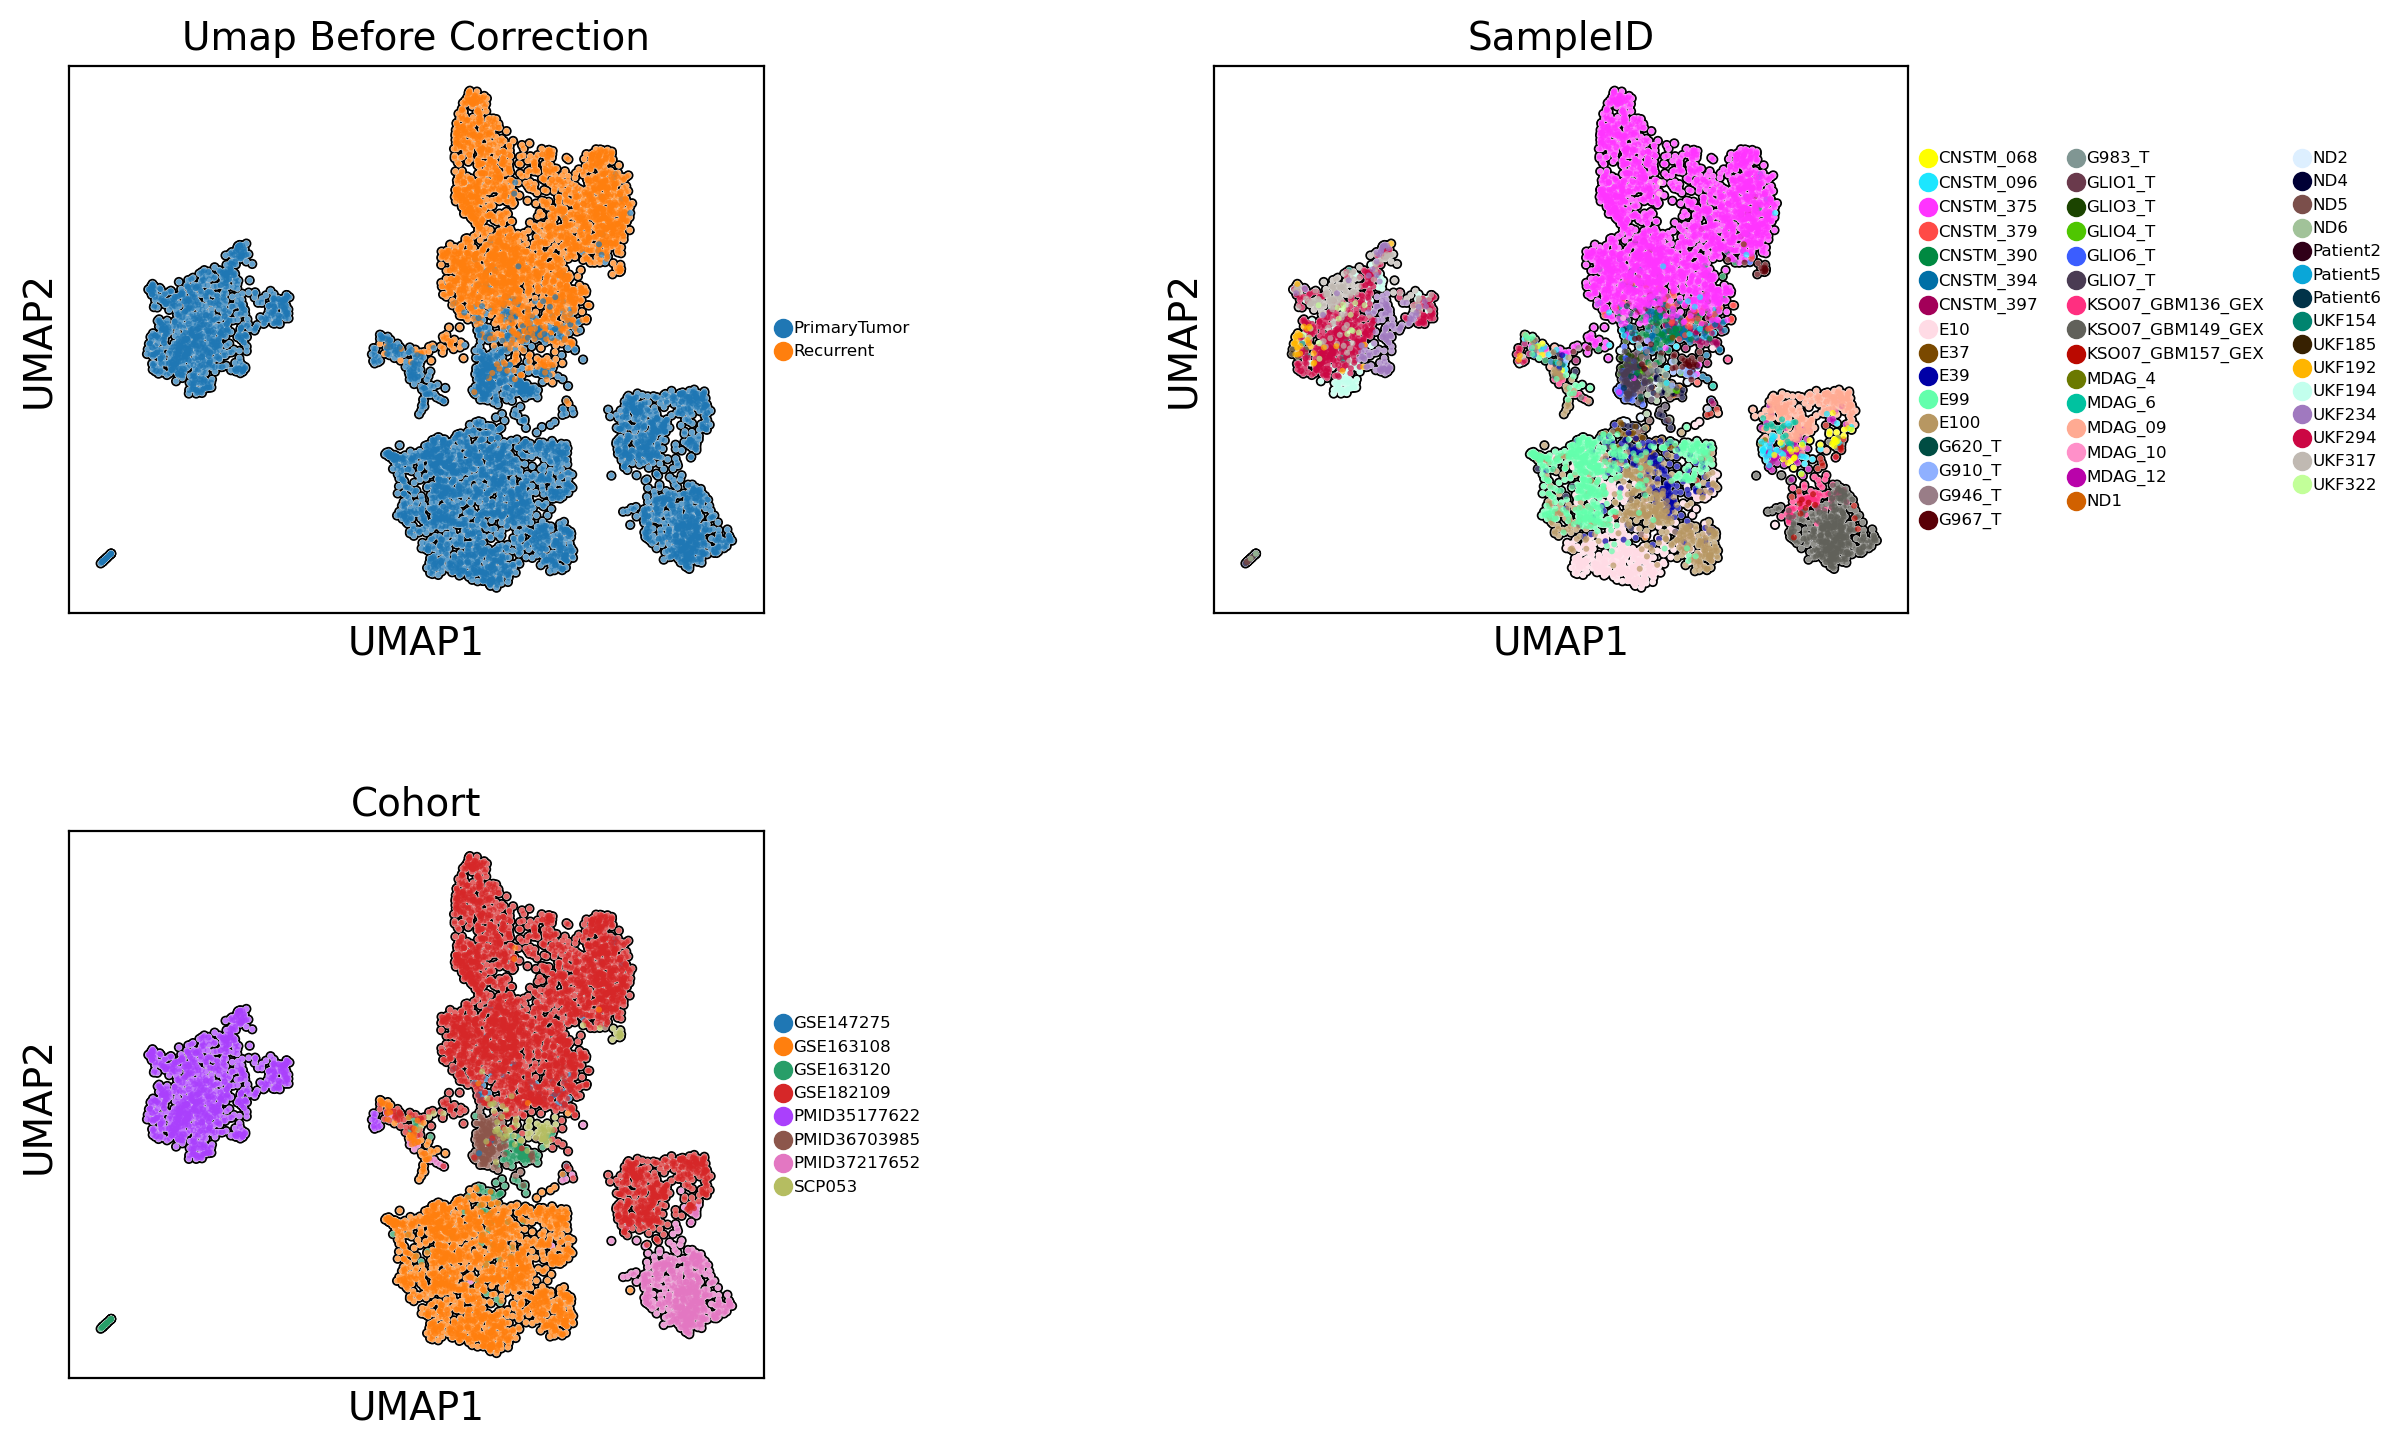

In [22]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort'], legend_fontsize=6, frameon=True, ncols = 2,
                        wspace=.5, hspace=0.4,
           title="Umap Before Correction",add_outline=True)

# Harmony correction

In [23]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, ['Type','SampleID','Cohort'])

2023-10-09 10:02:17,321 - harmonypy - INFO - Iteration 1 of 10
2023-10-09 10:02:18,724 - harmonypy - INFO - Iteration 2 of 10
2023-10-09 10:02:20,142 - harmonypy - INFO - Iteration 3 of 10
2023-10-09 10:02:21,529 - harmonypy - INFO - Iteration 4 of 10
2023-10-09 10:02:22,935 - harmonypy - INFO - Iteration 5 of 10
2023-10-09 10:02:24,198 - harmonypy - INFO - Iteration 6 of 10
2023-10-09 10:02:25,592 - harmonypy - INFO - Iteration 7 of 10
2023-10-09 10:02:26,933 - harmonypy - INFO - Iteration 8 of 10
2023-10-09 10:02:27,942 - harmonypy - INFO - Iteration 9 of 10
2023-10-09 10:02:28,707 - harmonypy - INFO - Converged after 9 iterations


# Umap After Harmony Correction

In [30]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.3)

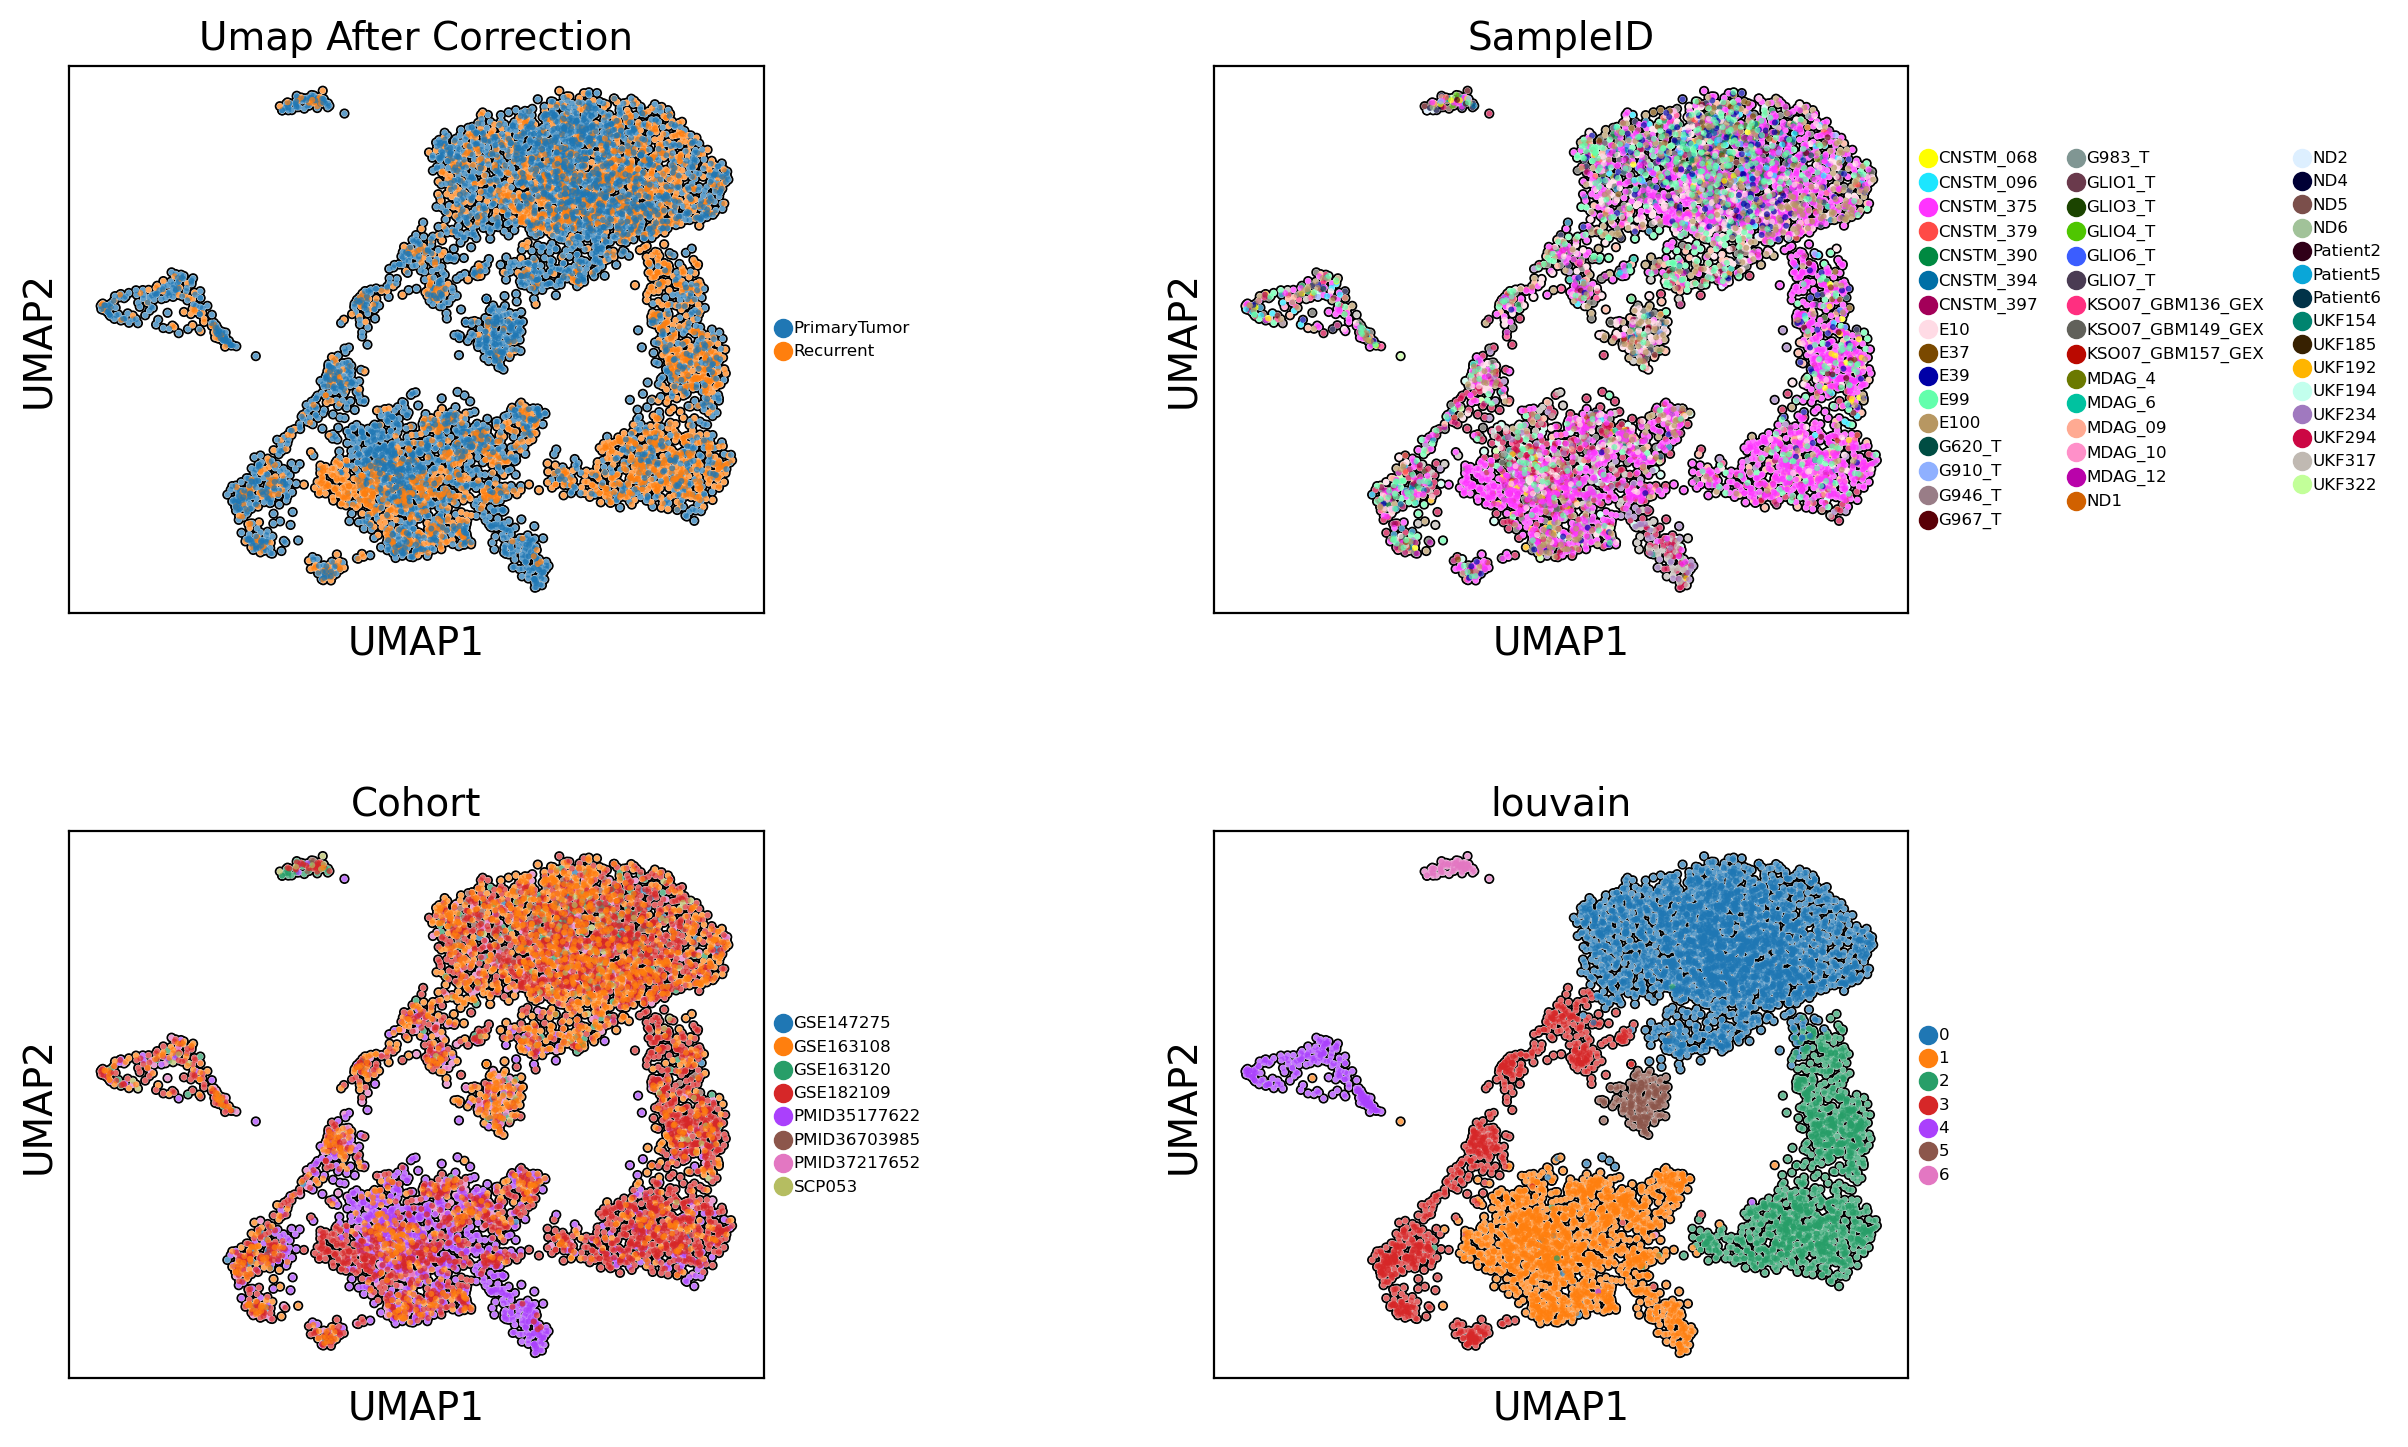

In [31]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort','louvain'], legend_fontsize=6, frameon=True, ncols = 2,
                        wspace=.5, hspace=0.4, title="Umap After Correction",add_outline=True)

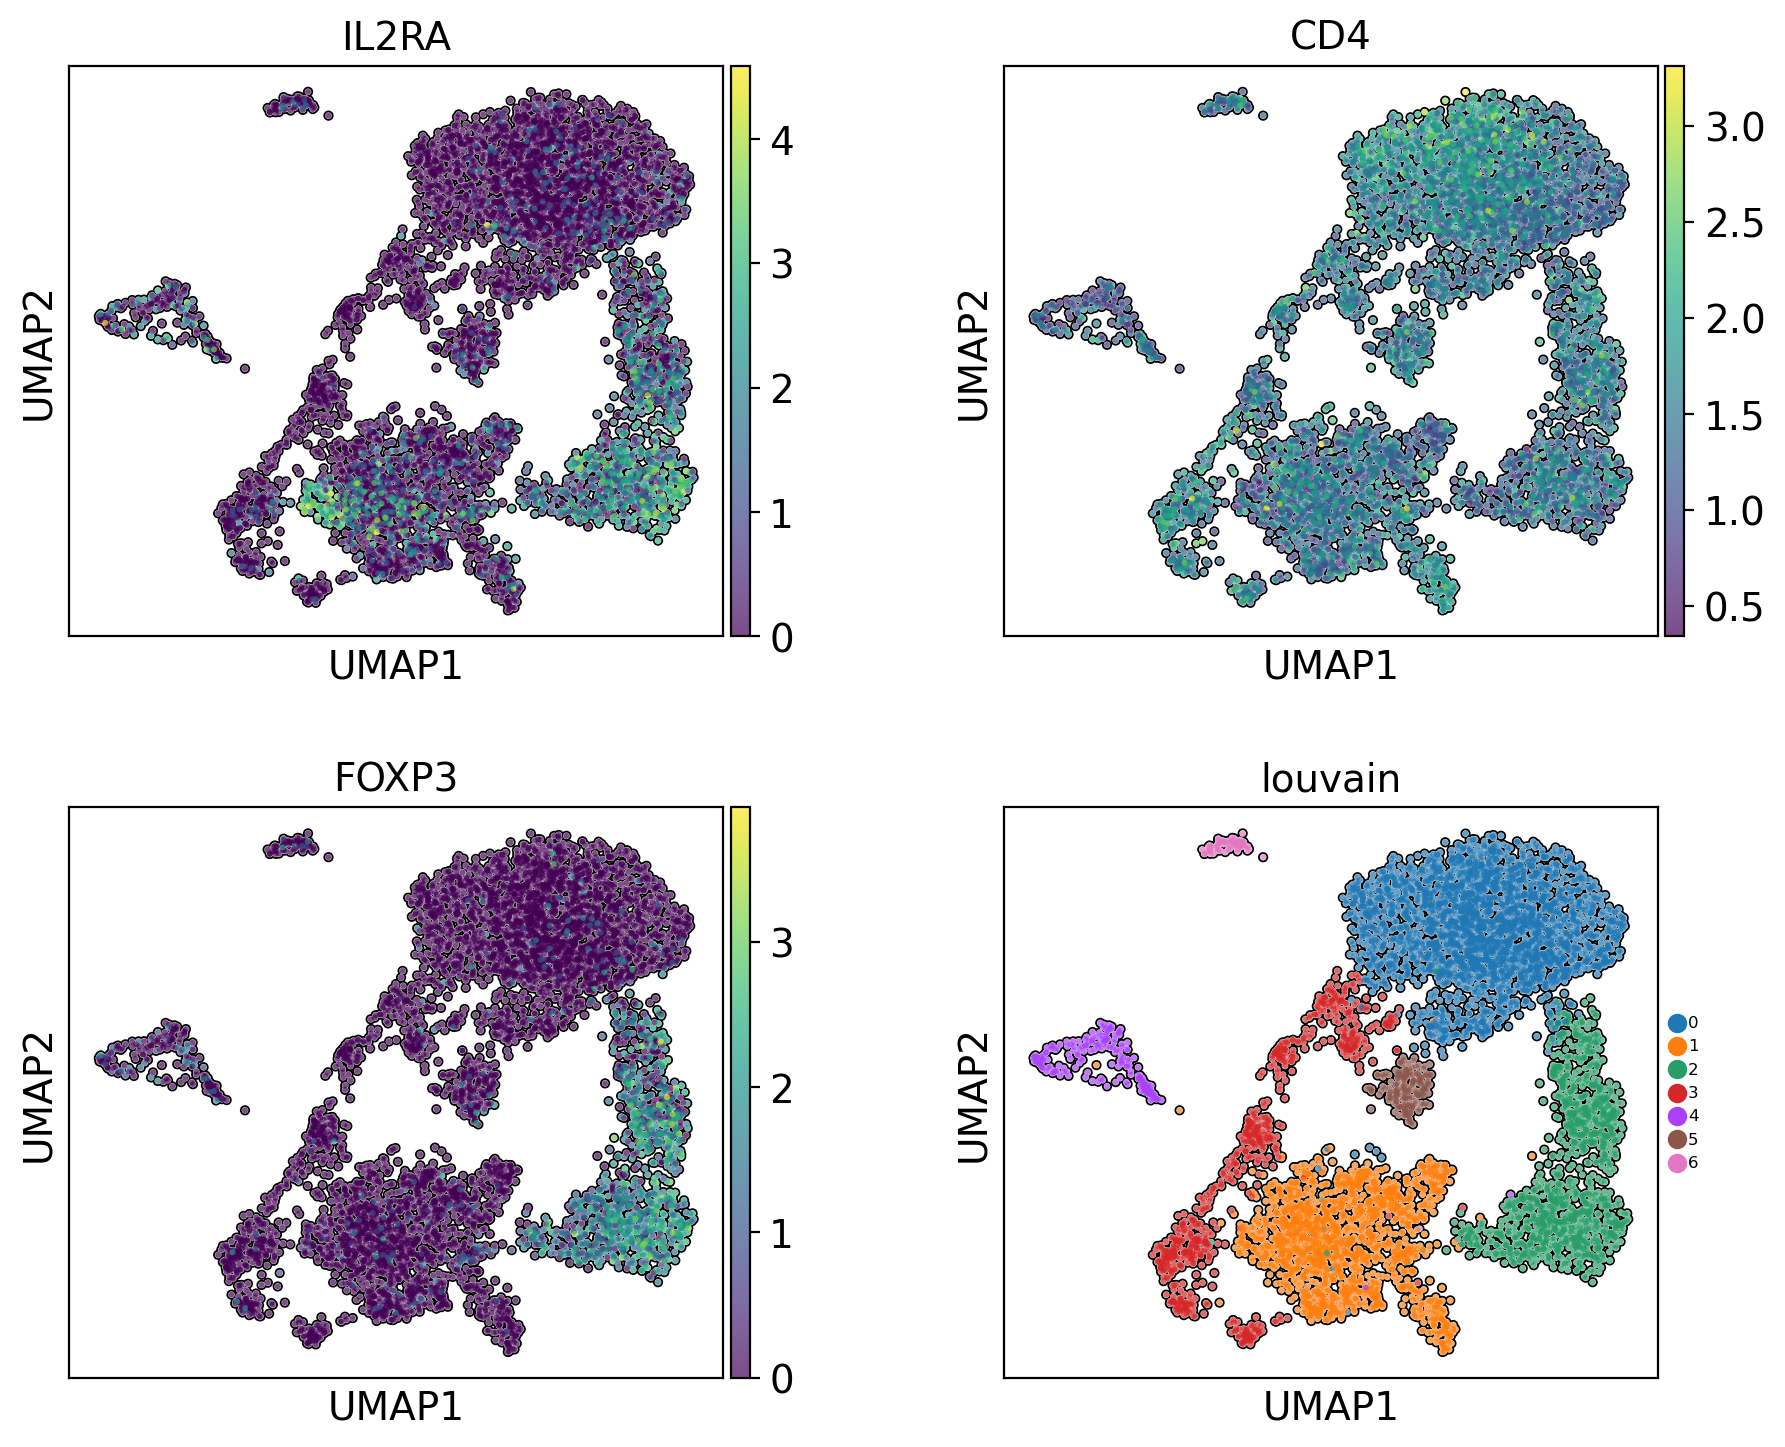

In [32]:
sc.pl.umap(adata, color=["IL2RA", "CD4", "FOXP3","louvain"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

In [34]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon',pts=0.20)

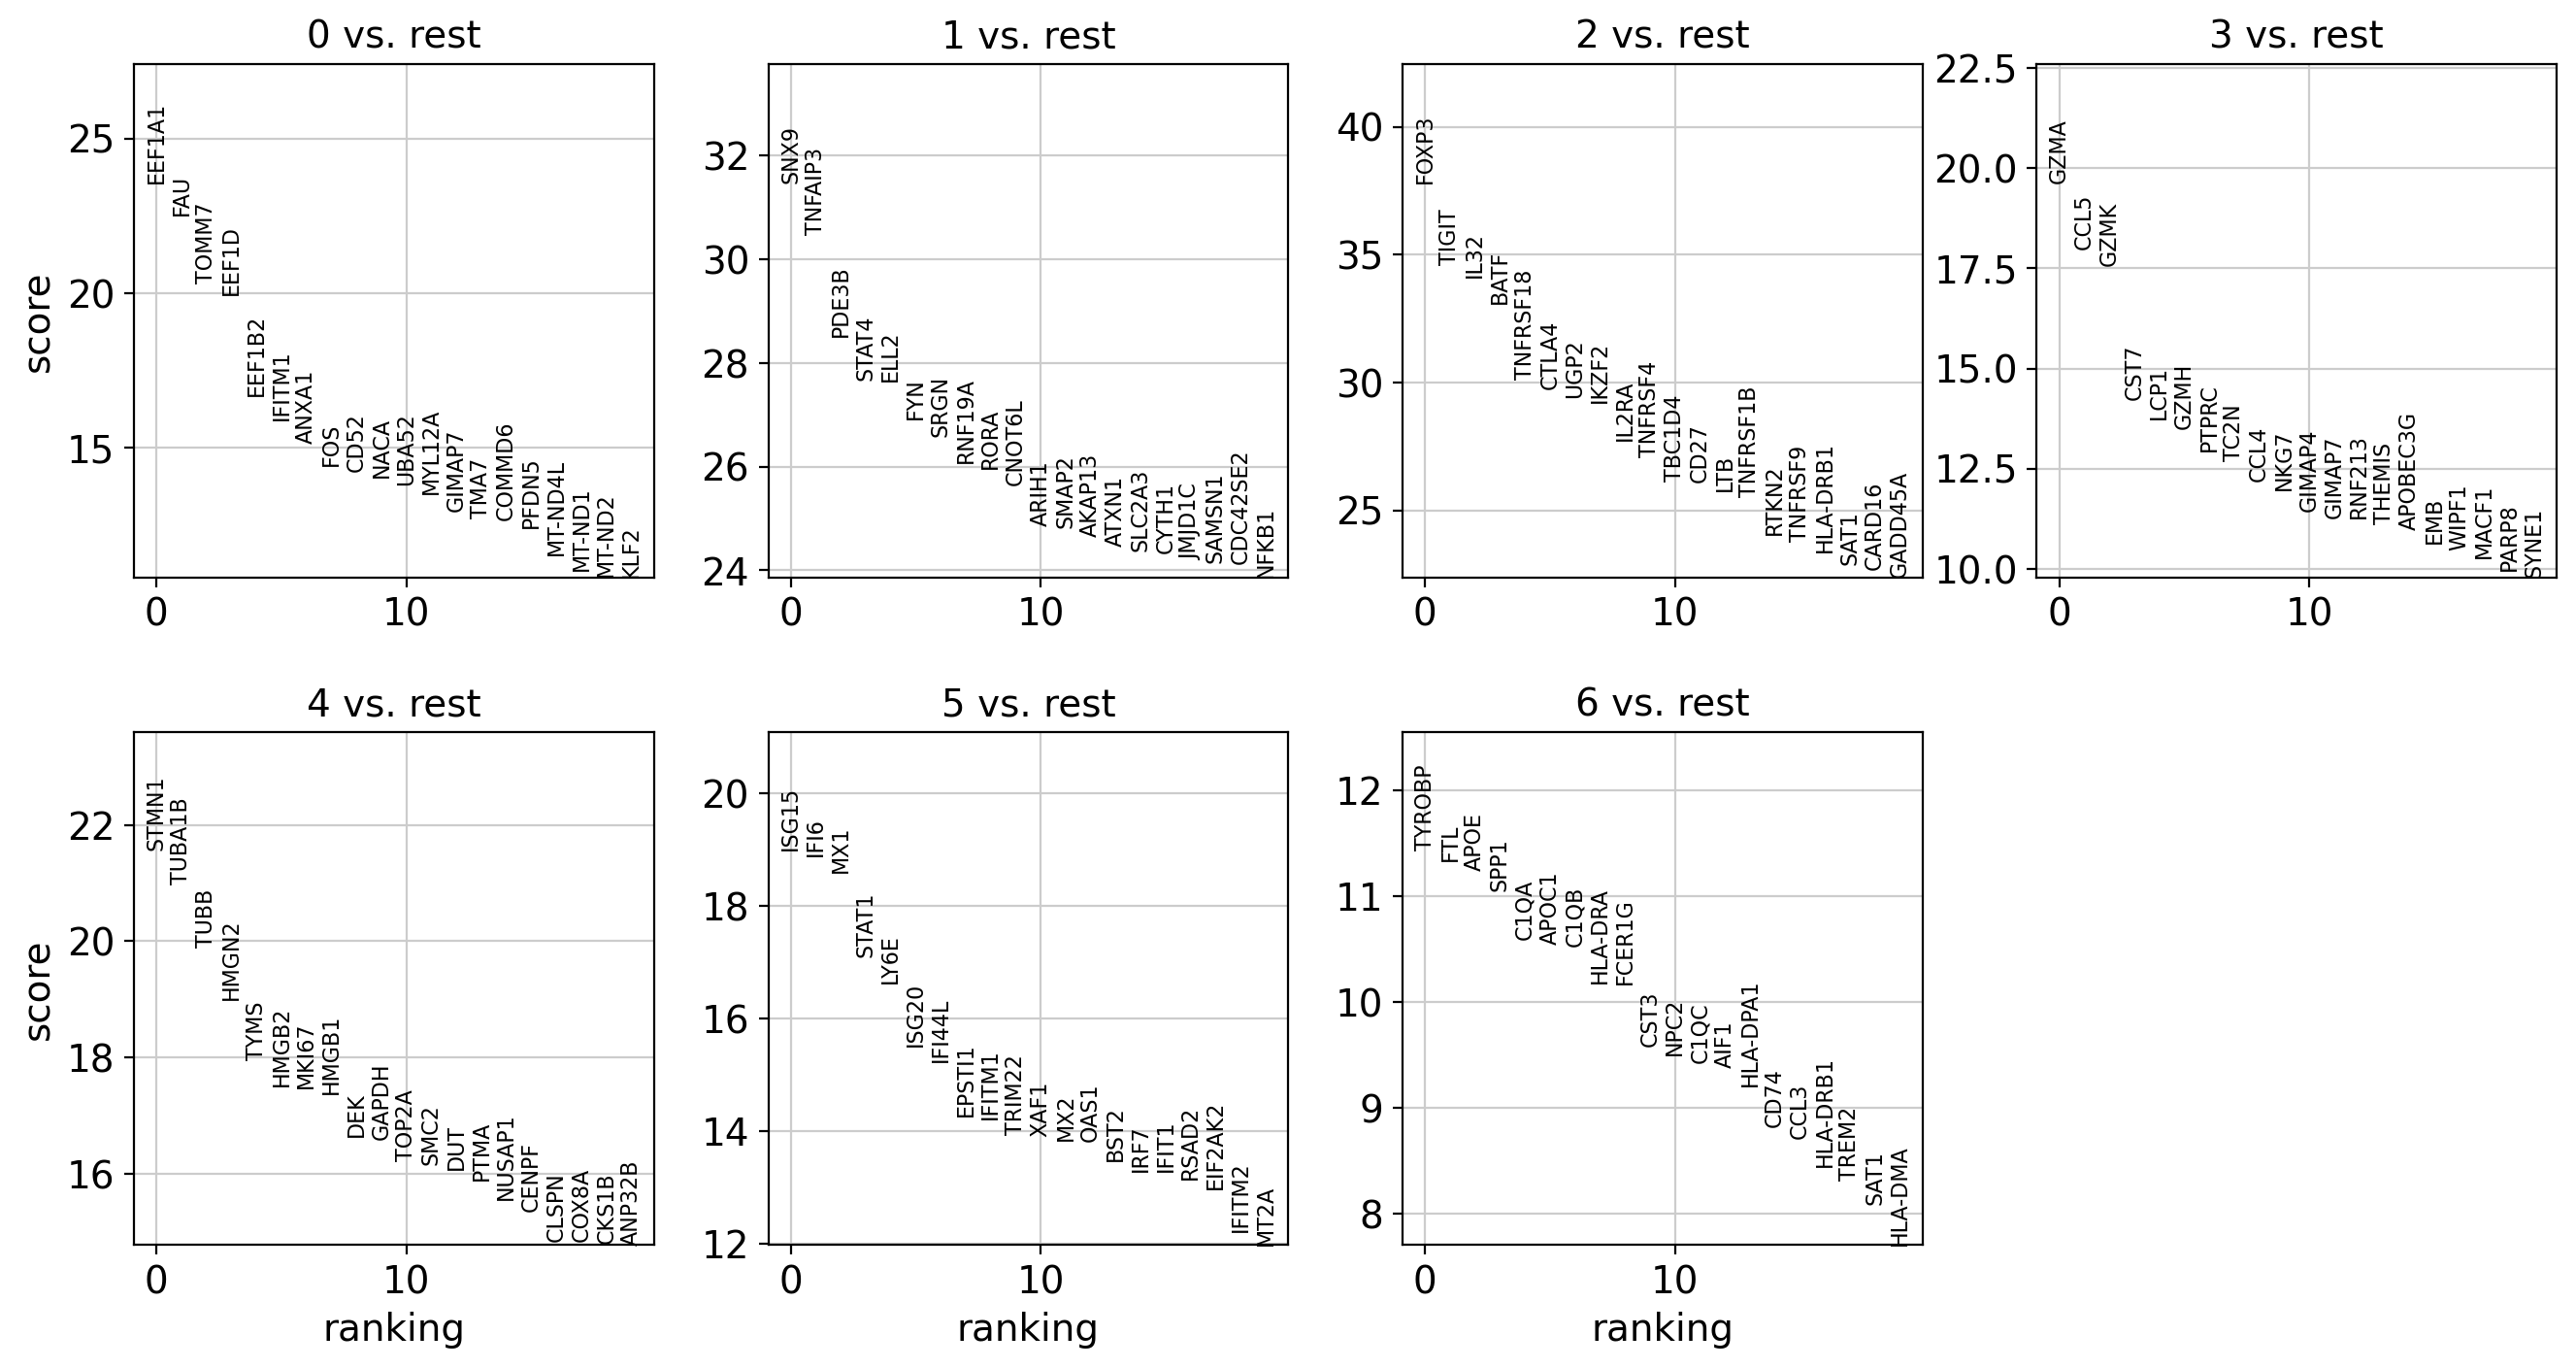

In [35]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Plot Heatmap

In [36]:
import cytocipher as cc

In [37]:
adata_all = adata.raw.to_adata()

Added data.uns['louvain_markers']
Added data.obsm['louvain_enrich_scores']


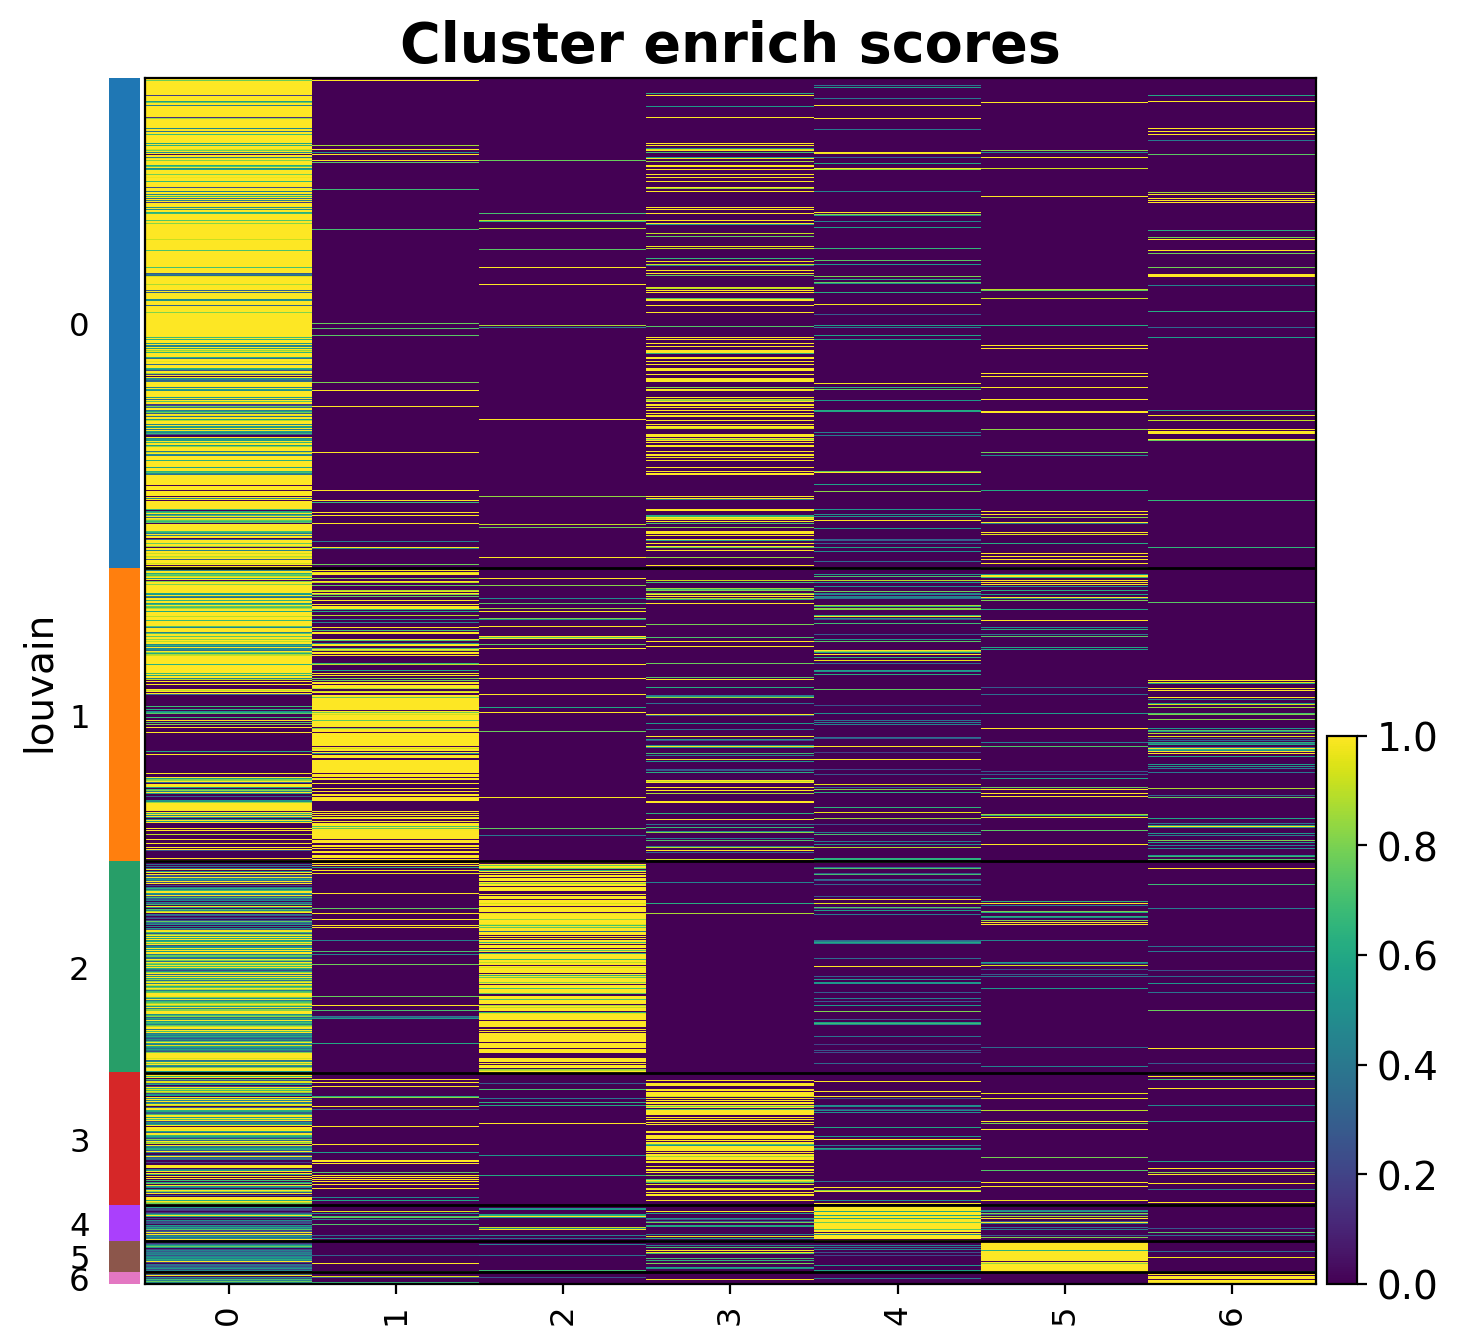

In [38]:
cc.tl.get_markers(adata_all, 'louvain')
cc.tl.code_enrich(adata_all, 'louvain')
cc.pl.enrich_heatmap(adata_all, 'louvain',n_clust_cells=None)

# Export Marker Genes

In [39]:
result = adata.uns['rank_genes_groups']

In [40]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/CD4_MarkerGenes.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)

In [41]:
result = adata_all.uns['rank_genes_groups']

In [42]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/CD4_DEGS.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata_all, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)

# Plot Frequency

## Type

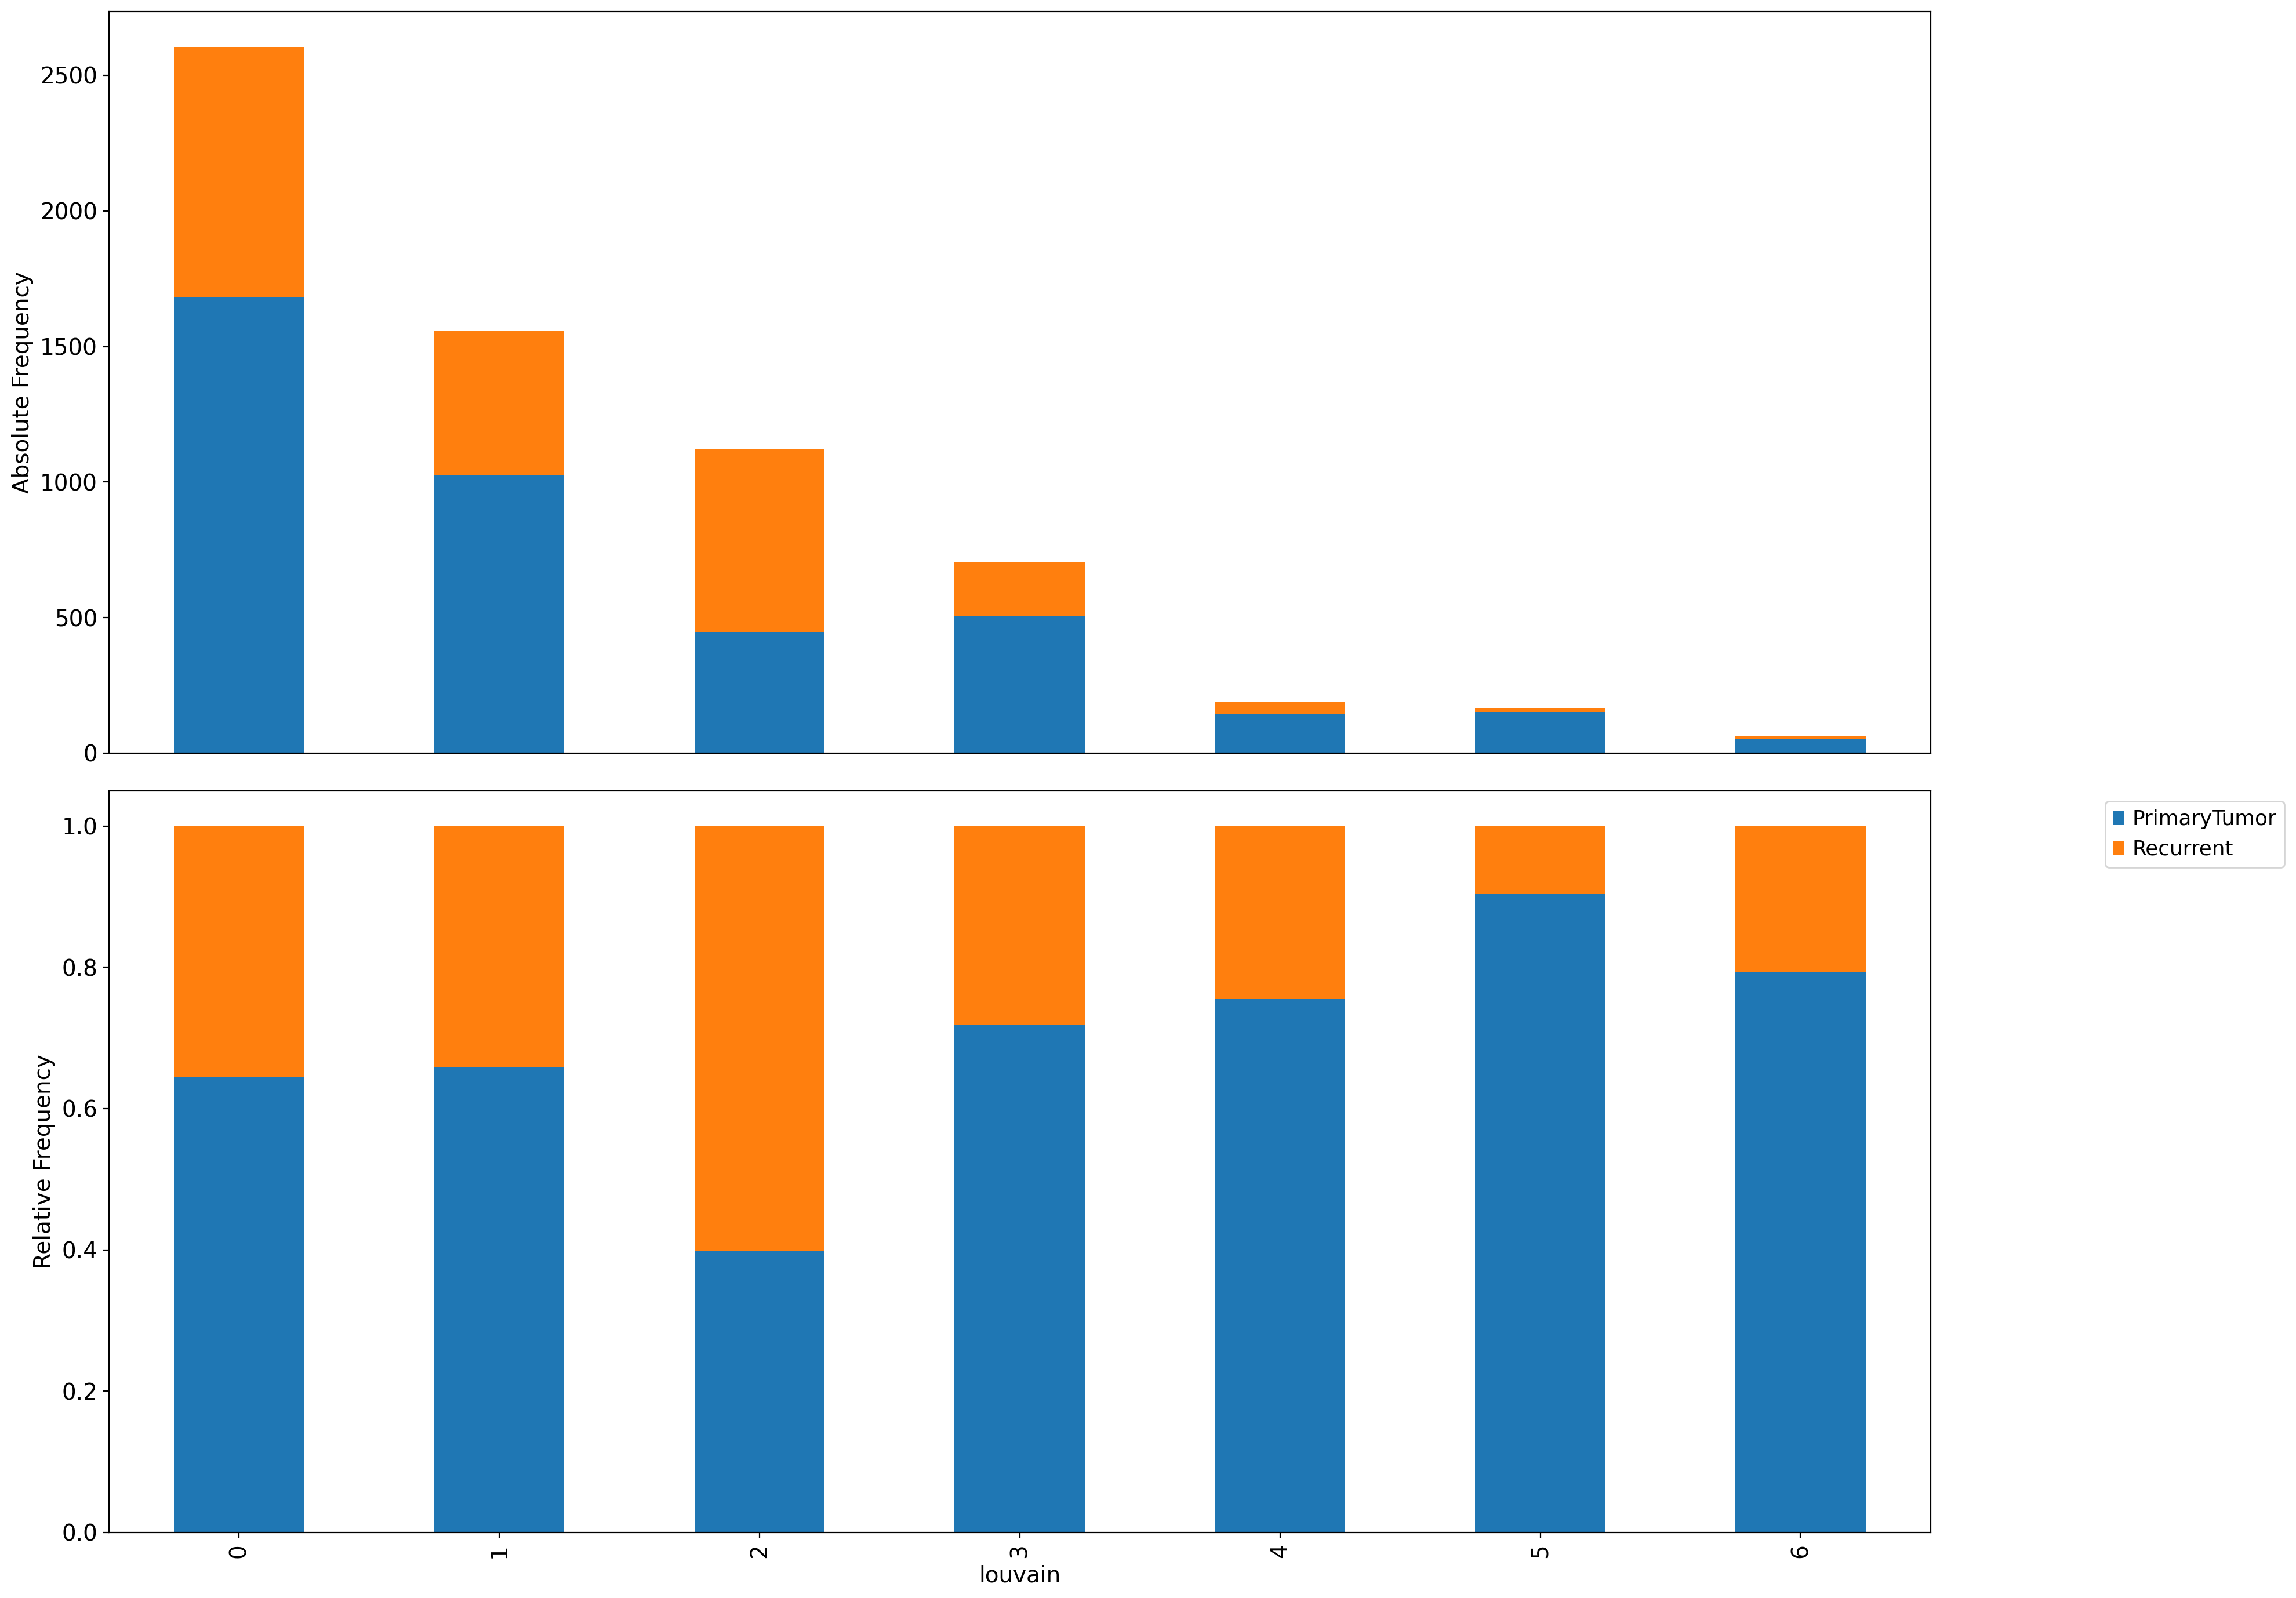

In [43]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Type"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Type"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

In [44]:
df = pd.DataFrame(adata.obs.groupby("louvain")["Type","Sample"].value_counts(normalize=True))

In [45]:
df.to_csv("./test2.csv",sep="\t",header=True,index=True)

In [46]:
df2 = pd.read_csv("./test2.csv",sep="\t",header=0)

In [47]:
df2 = df2.loc[df2['0']>0]

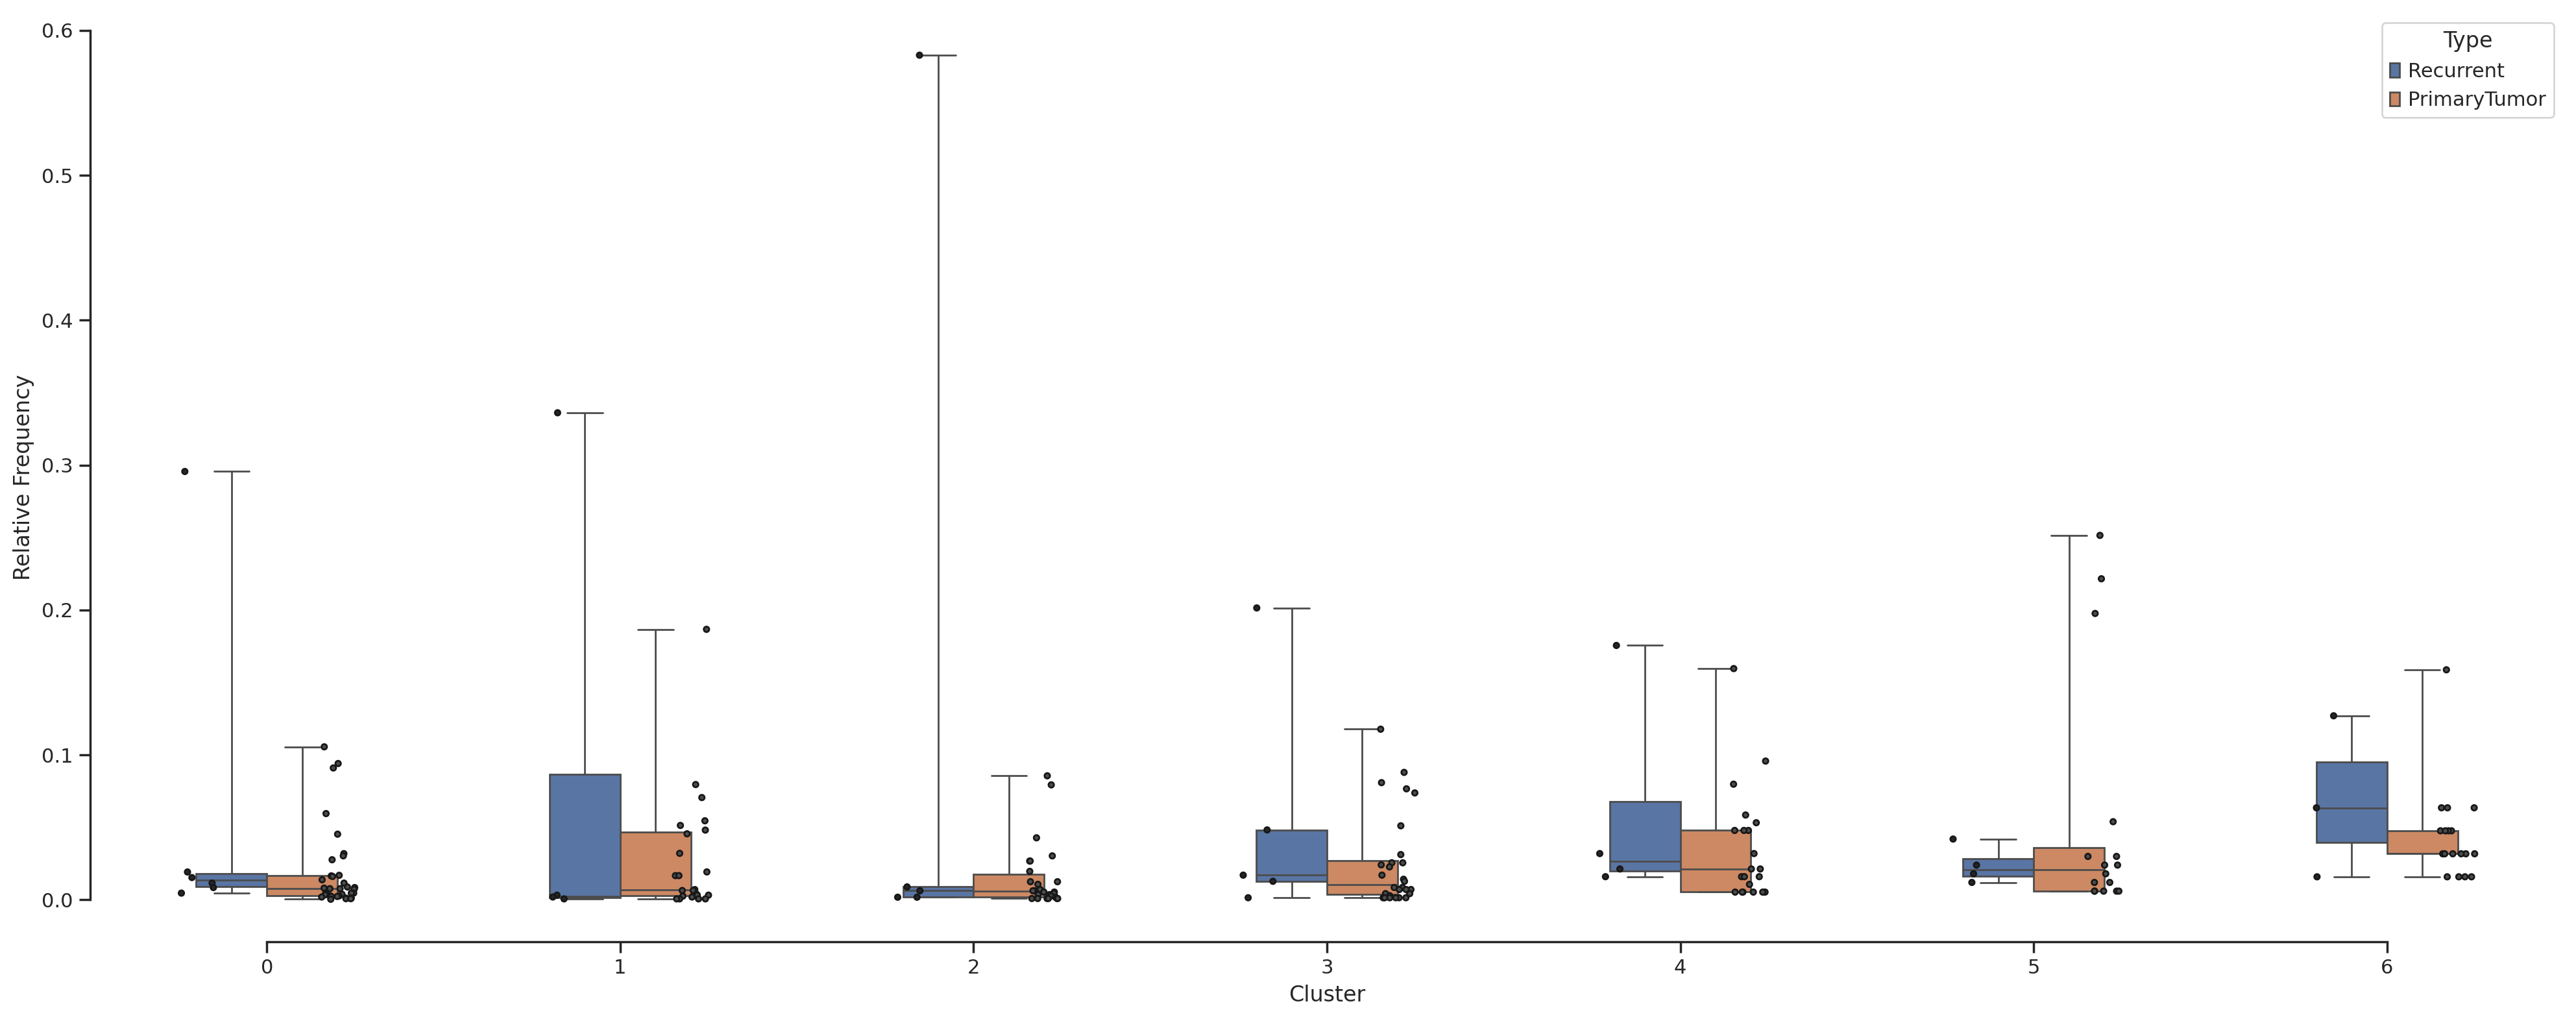

In [48]:
sns.set(rc={'font.family':'Arial', 'font.serif':'Arial'})
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 8))
ax = sns.boxplot(data=df2, x="louvain", y="0",hue="Type",
                 whis=[0, 100], width=.4,dodge=True)
ax = sns.stripplot(x="louvain", y="0", data=df2,hue="Type",dodge=True,legend=False,
              size=3, color=".3", linewidth=1)

#add_stat_annotation(ax, data=df2, x="louvain", y="0",hue="Type",
#                                   test='t-test_welch',box_pairs=pairs,
#                                   comparisons_correction=None,
#                                   loc='inside', verbose=2)

ax.xaxis.grid(False)
ax.set(ylabel="Relative Frequency")
ax.set(xlabel="Cluster")
sns.despine(trim=True, left=False)
plt.tight_layout()

# Cohort

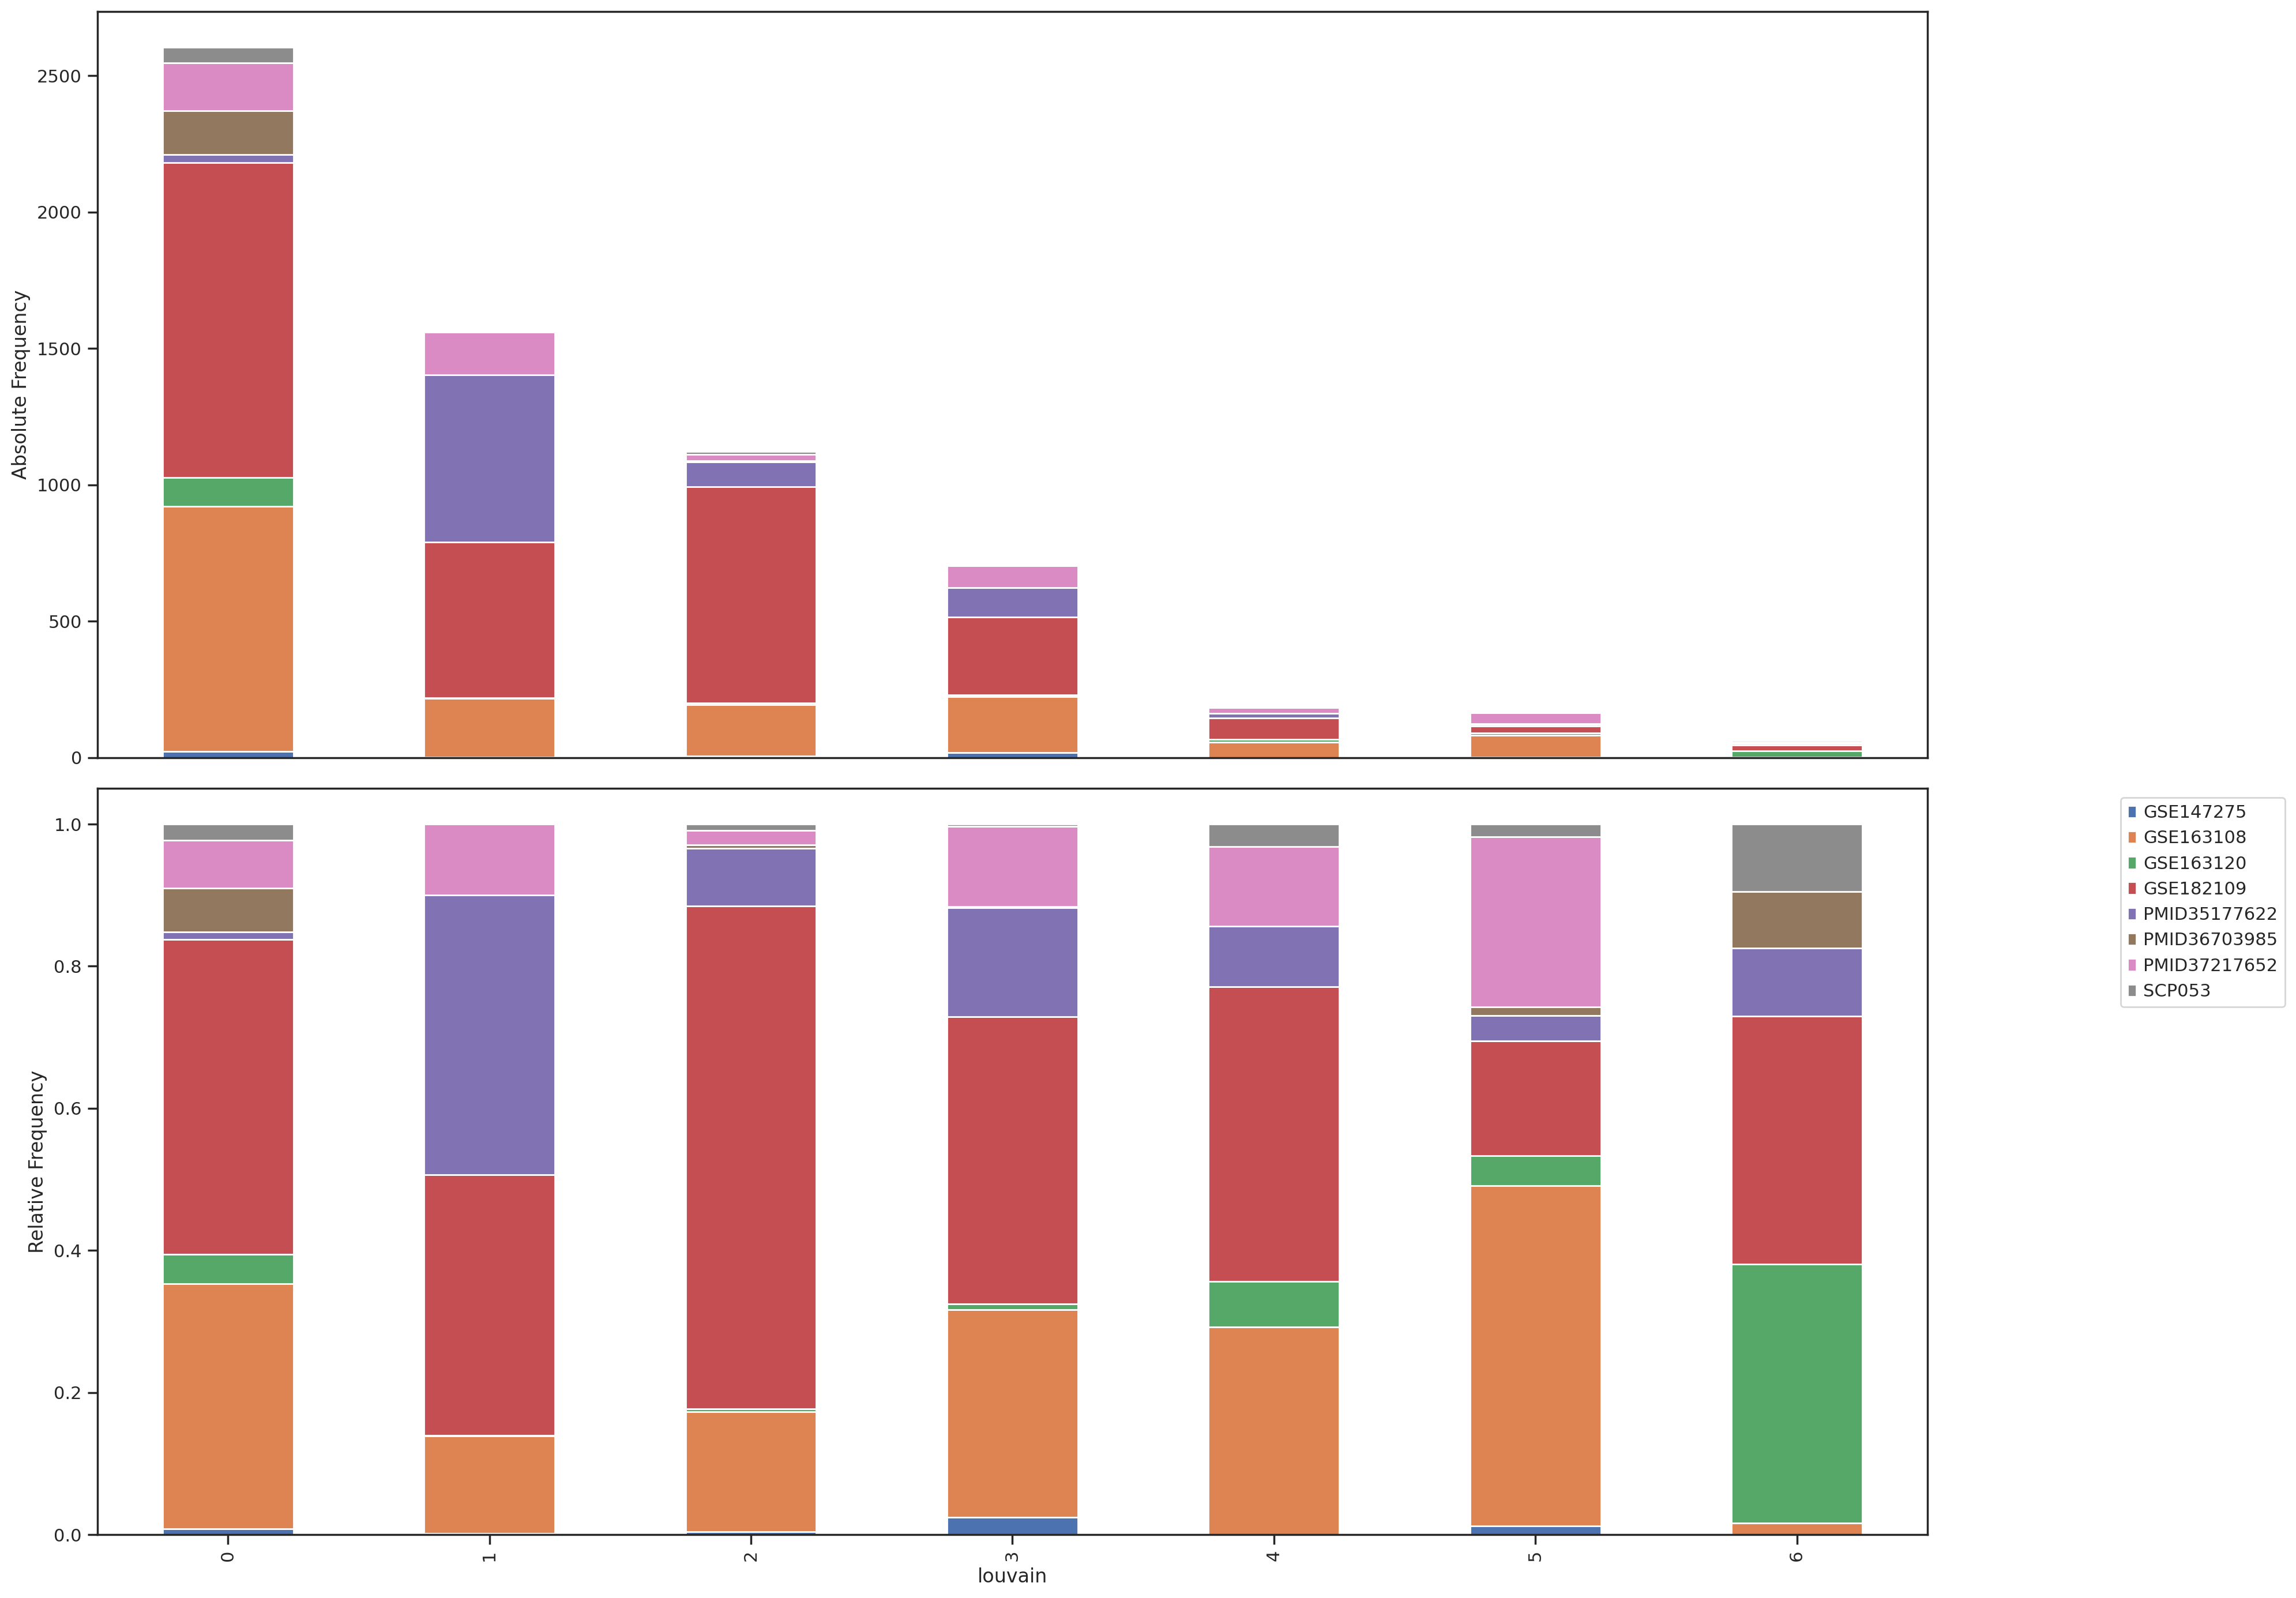

In [49]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Cohort"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Cohort"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

# SampleID

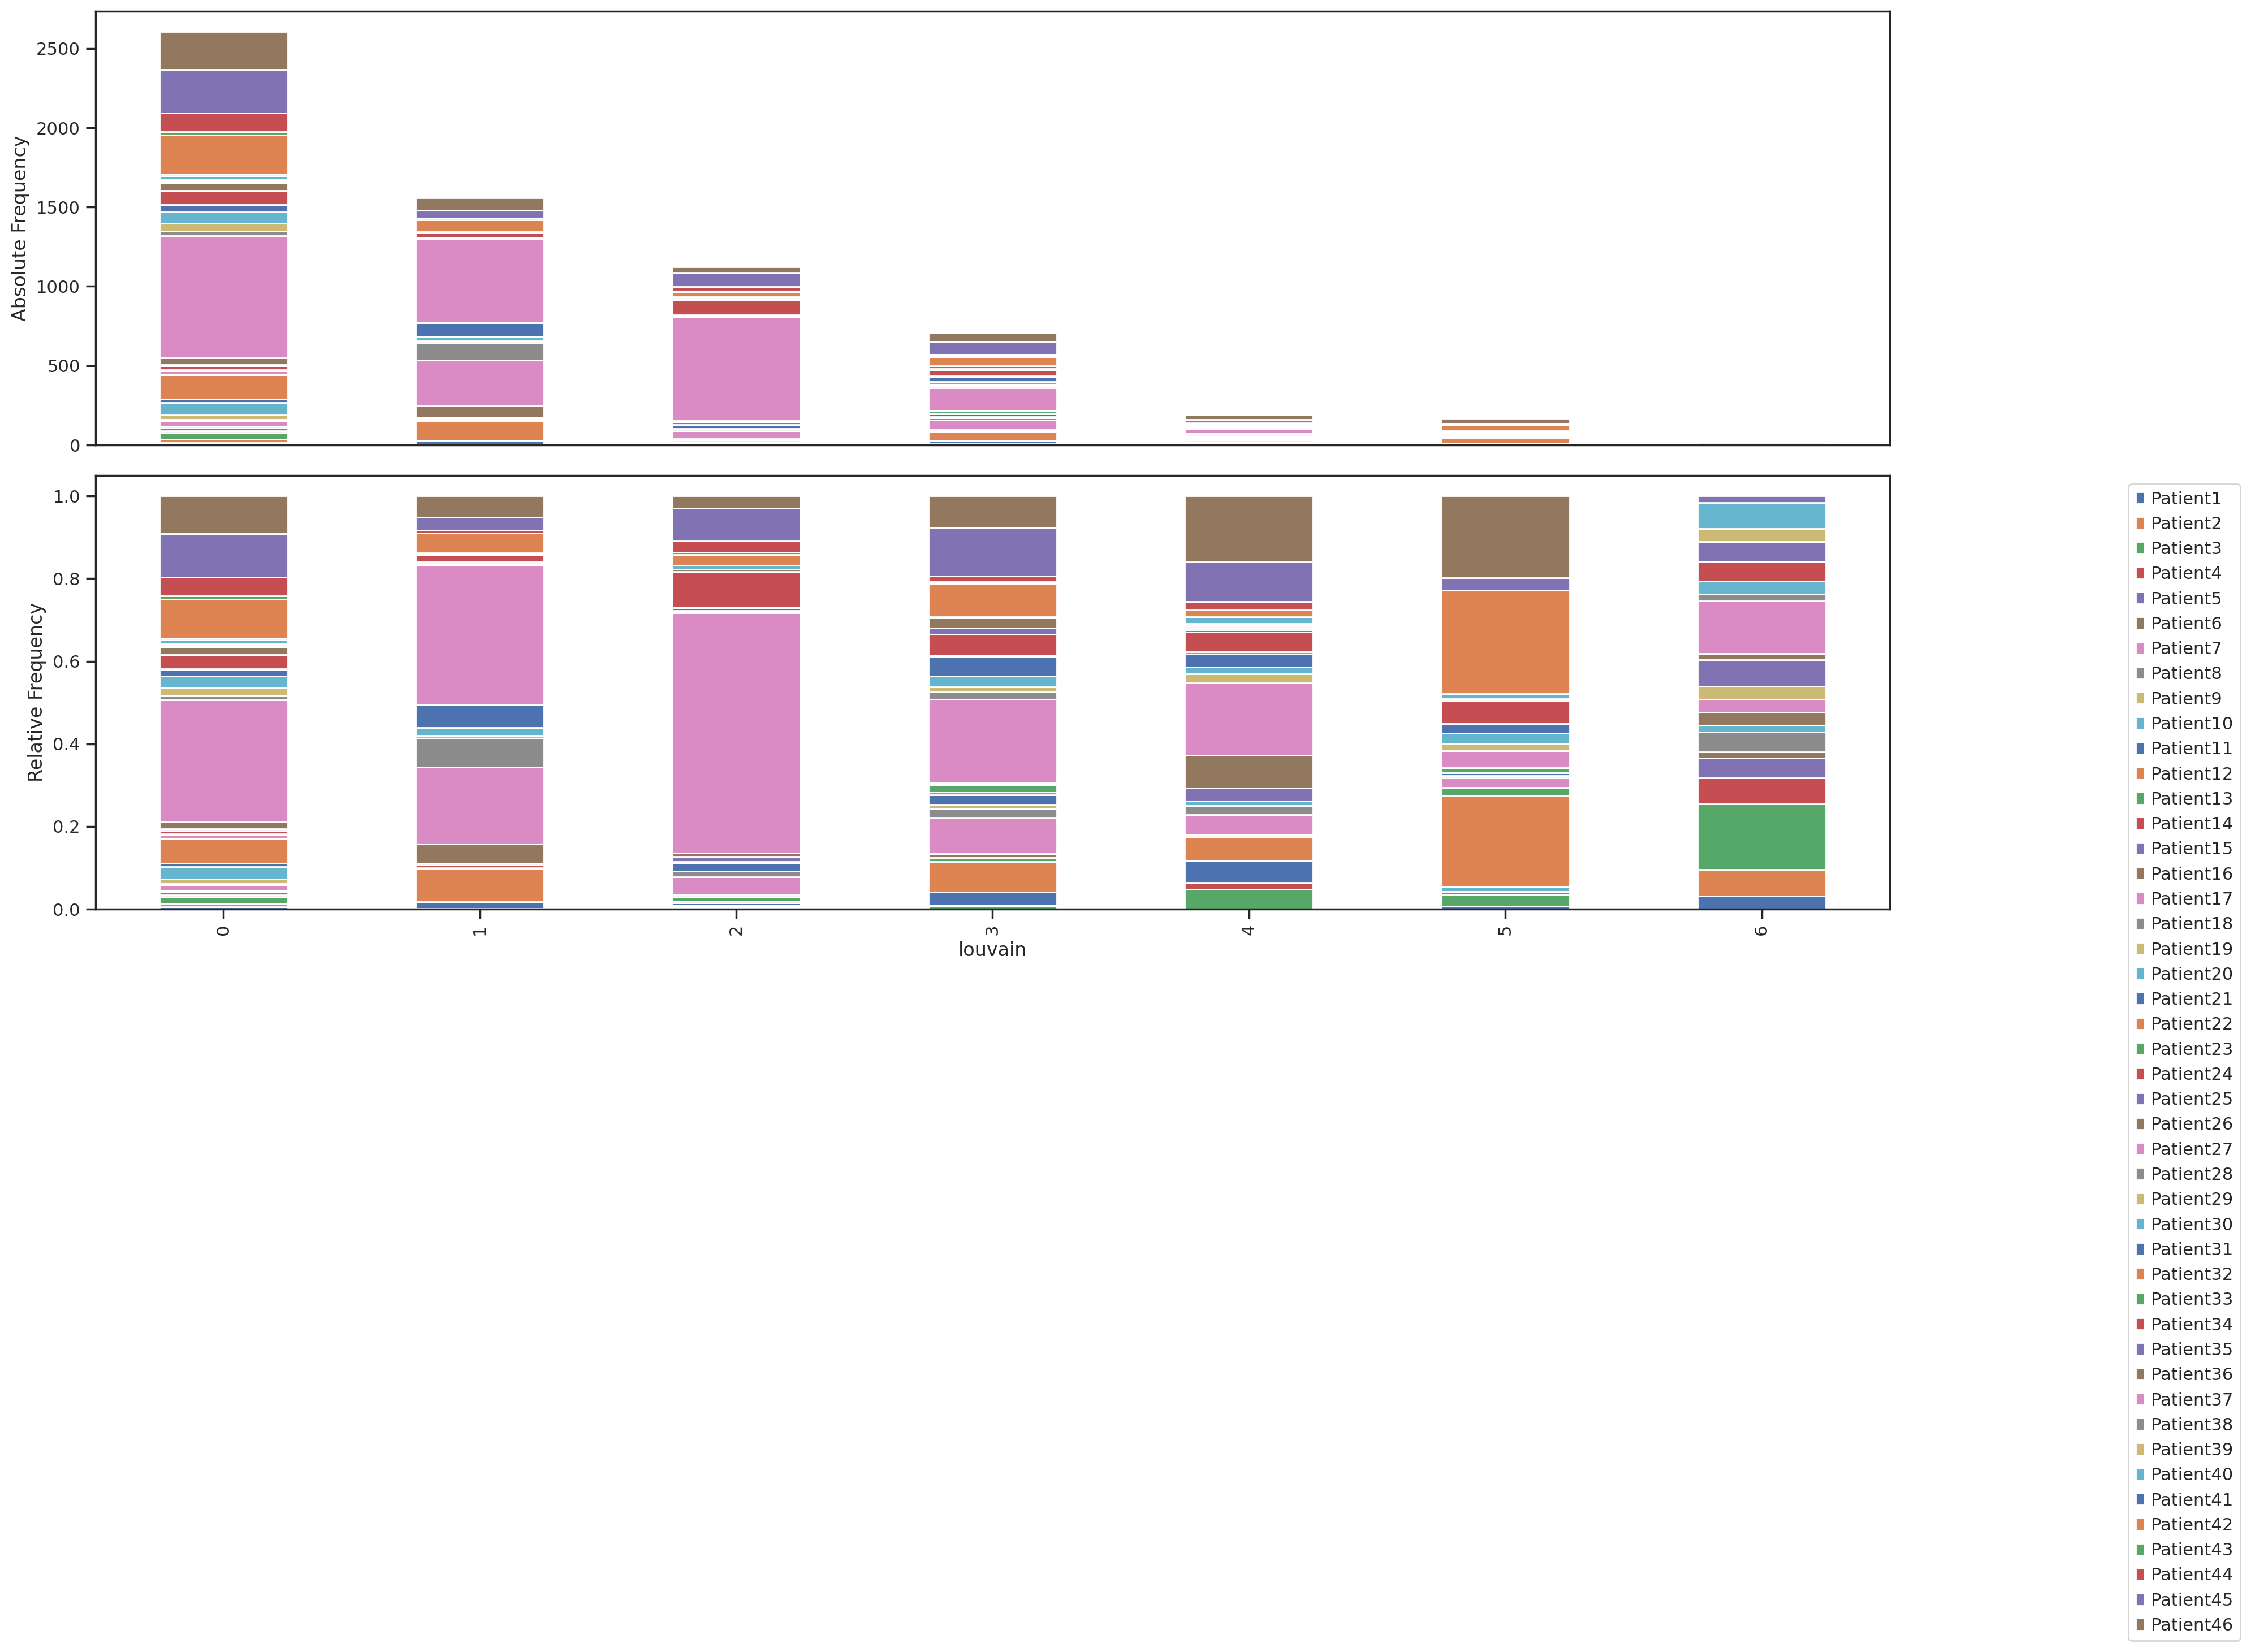

In [50]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("louvain")["Sample"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("louvain")["Sample"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()